# House Price Prediction: Regression


### Load Boston Housing Dataset

In [1]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets)= boston_housing.load_data()

Using TensorFlow backend.


In [2]:
print(train_data.shape)
print(train_targets.shape)
print(test_data.shape)
print(test_targets.shape)

(404, 13)
(404,)
(102, 13)
(102,)


404 training samples and 102 test samples, each with 13 numerical features, such as per capita crime rate, average number of rooms per dwelling, accessibility to highways, and so on.

The targets are the median values of owner-occupied homes, in thousands of dollars

In [3]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

### Prepare the Data

It would be problematic to feed into a neural network values that all take wildly different ranges. The network might be able to automatically adapt to such heterogeneous data, but it would definitely make learning more difficult. One of the best practice
to deal with such data is to do **feature-wise normalization**: *for each feature in the input data (a column in the input data matrix), you subtract the mean of the feature and divide by the standard deviation, so that the feature is centered around 0 and has a unit standard deviation*.

#### Normalize the Data

the quantities used for normalizing the test data are computed using the training data. One should never use in workflow any quantity computed on the test data, even for something as simple as data normalization

In [4]:
mean= train_data.mean(axis=0)
std= train_data.std(axis=0)

train_data -= mean
train_data /=std

test_data -= mean
test_data /=std

In [5]:
train_data

array([[-0.27224633, -0.48361547, -0.43576161, ...,  1.14850044,
         0.44807713,  0.8252202 ],
       [-0.40342651,  2.99178419, -1.33391162, ..., -1.71818909,
         0.43190599, -1.32920239],
       [ 0.1249402 , -0.48361547,  1.0283258 , ...,  0.78447637,
         0.22061726, -1.30850006],
       ...,
       [-0.40202987,  0.99079651, -0.7415148 , ..., -0.71712291,
         0.07943894, -0.67776904],
       [-0.17292018, -0.48361547,  1.24588095, ..., -1.71818909,
        -0.98764362,  0.42083466],
       [-0.40422614,  2.04394792, -1.20161456, ..., -1.30866202,
         0.23317118, -1.15392266]])

### Building Netwrok

#### Define Model 

In [6]:
from keras import models
from keras import layers

def build_model():
    model= models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

The network ends with a **single unit** and **no activation (it will be a linear layer)**. This is a typical setup for scalar regression (a regression trying to predict a *single continuous value*). Applying an activation function would constrain the range the output can take; for instance, if we applied a sigmoid activation function to the last layer, the network could only learn to predict values between 0 and 1. Here, because the last layer is purely linear, the network is free to learn to predict values in any range.

We are compiling the network with the ```mse``` loss function—```mean squared error```, the *square of the difference between the predictions and the targets*. This is a widely used loss function for regression problems.

We are using ```mean absolute error (MAE)``` metric for training. It’s the *absolute value of the difference between the predictions and the targets*. For instance, an ```MAE``` of **0.5** on this problem would mean our predictions are off by **$500** on average


### Validation: Using k-fold cross-validation

To evaluate the network while adjusting its parameters, we could split the data into a training set and a validation set. But if we have few data points, the validation set would end up being very small (for instance, about 100 examples). As a consequence, the validation scores might change a lot depending on which data points we chose to use for validation and which we chose for training. 
The validation scores might have a high variance with regard to the validation split. This would prevent reliably in evaluating model.
The best practice in such situations is to use ```K-fold cross-validation```.
It consists of splitting the available data into **K partitions (typically K = 4 or 5)** , instantiating ***K*** identical models, and training each one on **K – 1** partitions while evaluating on the remaining partition. The validation score for the model used is then the average of the **K** validation scores obtained. 

![capture](https://user-images.githubusercontent.com/13174586/49578198-2e672d80-f96f-11e8-948b-a3489fefd11f.JPG)


In [7]:
import numpy as np
k=4
num_val_samples= len(train_data)//k # 404/4=101
print("No. of Validation Samples: ", num_val_samples)
num_epochs=100
all_scores=[]

No. of Validation Samples:  101


In [11]:
# Prepares validation data from partition #k

for i in range(k):
    print("Processing_fold: #", i+1)
    
    val_data= train_data[i*num_val_samples:(i+1)*num_val_samples]
    val_targets= train_targets[i*num_val_samples:(i+1)*num_val_samples]
    
    partial_train_data= np.concatenate([
        train_data[:i*num_val_samples],
        train_data[(i+1)*num_val_samples:]], axis=0)
    
    #Prepare training data from all other partitions
    partial_train_targets= np.concatenate([
        train_targets[:i*num_val_samples],
        train_targets[(i+1)*num_val_samples:]], axis=0)
    
    #Build Keras model already compiled
    model= build_model()
    #train the model
    model.fit(partial_train_data, partial_train_targets, 
             epochs=num_epochs, batch_size=1) # verbose=0 will train the model in silent mode
    val_mse, val_mae= model.evaluate(val_data, val_targets) # verbose=0 will train the model in silent mode
    all_scores.append(val_mae)

Processing_fold: # 1
Epoch 1/100
303/303 [==============================] - 1s 3ms/step - loss: 182.4080 - mean_absolute_error: 10.2613
Epoch 2/100
303/303 [==============================] - 1s 2ms/step - loss: 33.5639 - mean_absolute_error: 3.9215
Epoch 3/100
303/303 [==============================] - 1s 2ms/step - loss: 23.7305 - mean_absolute_error: 3.2318
Epoch 4/100
303/303 [==============================] - 1s 2ms/step - loss: 19.0194 - mean_absolute_error: 2.8497
Epoch 5/100
303/303 [==============================] - 1s 2ms/step - loss: 17.0039 - mean_absolute_error: 2.7641
Epoch 6/100
303/303 [==============================] - 1s 2ms/step - loss: 15.3810 - mean_absolute_error: 2.5659
Epoch 7/100
303/303 [==============================] - 1s 2ms/step - loss: 14.0390 - mean_absolute_error: 2.4407
Epoch 8/100
303/303 [==============================] - 1s 2ms/step - loss: 13.2660 - mean_absolute_error: 2.4720
Epoch 9/100
303/303 [==============================] - 1s 2ms/step - loss

303/303 [==============================] - 1s 2ms/step - loss: 5.0348 - mean_absolute_error: 1.5295
Epoch 74/100
303/303 [==============================] - 1s 2ms/step - loss: 5.1942 - mean_absolute_error: 1.4958
Epoch 75/100
303/303 [==============================] - 1s 2ms/step - loss: 4.7939 - mean_absolute_error: 1.5087
Epoch 76/100
303/303 [==============================] - 1s 2ms/step - loss: 5.4424 - mean_absolute_error: 1.5799
Epoch 77/100
303/303 [==============================] - 1s 2ms/step - loss: 5.0102 - mean_absolute_error: 1.5197
Epoch 78/100
303/303 [==============================] - 1s 2ms/step - loss: 4.7568 - mean_absolute_error: 1.4624
Epoch 79/100
303/303 [==============================] - 1s 2ms/step - loss: 5.1023 - mean_absolute_error: 1.4925
Epoch 80/100
303/303 [==============================] - 1s 2ms/step - loss: 5.0857 - mean_absolute_error: 1.5663
Epoch 81/100
303/303 [==============================] - 1s 2ms/step - loss: 4.7536 - mean_absolute_error: 1.4

303/303 [==============================] - 1s 2ms/step - loss: 6.2253 - mean_absolute_error: 1.6591
Epoch 45/100
303/303 [==============================] - 1s 2ms/step - loss: 6.1745 - mean_absolute_error: 1.6378
Epoch 46/100
303/303 [==============================] - 1s 2ms/step - loss: 6.3233 - mean_absolute_error: 1.6495
Epoch 47/100
303/303 [==============================] - 1s 2ms/step - loss: 6.2655 - mean_absolute_error: 1.5790
Epoch 48/100
303/303 [==============================] - 1s 2ms/step - loss: 6.5324 - mean_absolute_error: 1.6460
Epoch 49/100
303/303 [==============================] - 1s 2ms/step - loss: 6.1826 - mean_absolute_error: 1.6019
Epoch 50/100
303/303 [==============================] - 1s 2ms/step - loss: 5.8256 - mean_absolute_error: 1.5851
Epoch 51/100
303/303 [==============================] - 1s 2ms/step - loss: 5.9845 - mean_absolute_error: 1.6295
Epoch 52/100
303/303 [==============================] - 1s 2ms/step - loss: 5.5672 - mean_absolute_error: 1.5

303/303 [==============================] - 1s 2ms/step - loss: 8.0403 - mean_absolute_error: 2.0232
Epoch 16/100
303/303 [==============================] - 1s 2ms/step - loss: 8.5733 - mean_absolute_error: 2.0352
Epoch 17/100
303/303 [==============================] - 1s 2ms/step - loss: 7.9550 - mean_absolute_error: 1.9626
Epoch 18/100
303/303 [==============================] - 1s 2ms/step - loss: 7.8692 - mean_absolute_error: 1.9257
Epoch 19/100
303/303 [==============================] - 1s 2ms/step - loss: 7.3566 - mean_absolute_error: 1.9762
Epoch 20/100
303/303 [==============================] - 1s 2ms/step - loss: 7.9087 - mean_absolute_error: 1.8854
Epoch 21/100
303/303 [==============================] - 1s 2ms/step - loss: 7.5324 - mean_absolute_error: 1.9229
Epoch 22/100
303/303 [==============================] - 1s 2ms/step - loss: 7.0770 - mean_absolute_error: 1.8224
Epoch 23/100
303/303 [==============================] - 1s 2ms/step - loss: 7.2656 - mean_absolute_error: 1.8

303/303 [==============================] - 1s 2ms/step - loss: 2.7532 - mean_absolute_error: 1.1602
Epoch 88/100
303/303 [==============================] - 1s 2ms/step - loss: 2.9005 - mean_absolute_error: 1.1995
Epoch 89/100
303/303 [==============================] - 1s 2ms/step - loss: 2.8933 - mean_absolute_error: 1.2175
Epoch 90/100
303/303 [==============================] - 1s 2ms/step - loss: 2.7966 - mean_absolute_error: 1.1881
Epoch 91/100
303/303 [==============================] - 1s 2ms/step - loss: 3.0168 - mean_absolute_error: 1.1989
Epoch 92/100
303/303 [==============================] - 1s 2ms/step - loss: 2.6693 - mean_absolute_error: 1.1432
Epoch 93/100
303/303 [==============================] - 1s 2ms/step - loss: 2.9449 - mean_absolute_error: 1.1931
Epoch 94/100
303/303 [==============================] - 1s 2ms/step - loss: 2.6951 - mean_absolute_error: 1.1406
Epoch 95/100
303/303 [==============================] - 1s 2ms/step - loss: 2.6362 - mean_absolute_error: 1.1

303/303 [==============================] - 1s 2ms/step - loss: 5.9330 - mean_absolute_error: 1.5646
Epoch 59/100
303/303 [==============================] - 1s 2ms/step - loss: 5.7515 - mean_absolute_error: 1.5578
Epoch 60/100
303/303 [==============================] - 1s 2ms/step - loss: 5.5975 - mean_absolute_error: 1.5755
Epoch 61/100
303/303 [==============================] - 1s 2ms/step - loss: 5.2966 - mean_absolute_error: 1.5301
Epoch 62/100
303/303 [==============================] - 1s 2ms/step - loss: 5.5974 - mean_absolute_error: 1.5679
Epoch 63/100
303/303 [==============================] - 1s 2ms/step - loss: 5.6493 - mean_absolute_error: 1.5090
Epoch 64/100
303/303 [==============================] - 1s 2ms/step - loss: 5.4850 - mean_absolute_error: 1.5348
Epoch 65/100
303/303 [==============================] - 1s 2ms/step - loss: 5.6921 - mean_absolute_error: 1.5778
Epoch 66/100
303/303 [==============================] - 1s 2ms/step - loss: 5.2880 - mean_absolute_error: 1.4

In [13]:
print(all_scores)
print(np.mean(all_scores))

[2.199616569103581, 2.361677087179505, 2.4760659378353913, 2.3145771758391125]
2.3379841924893974


The average (2.33) is a much more reliable metric than any single score—that’s the entire point of ```K-fold cross-validation```. In this case, we’re off by **$2,330** on average, which is significant considering that the prices range from $10,000 to $50,000. 

Let’s try training the network a bit longer: **500 epochs**. To keep a record of how well the model does at each epoch, we’ll modify the training loop to save the per epoch validation score log.

#### Save Validation Log at each fold

In [18]:
k=4
num_val_samples= len(train_data)//k # 404/4=101
print("No. of Validation Samples: ", num_val_samples)
num_epochs=500
all_mae_history=[]

# Prepares validation data from partition #k

for i in range(k):
    print("Processing_fold: #", i+1)
    
    val_data= train_data[i*num_val_samples:(i+1)*num_val_samples]
    val_targets= train_targets[i*num_val_samples:(i+1)*num_val_samples]
    
    partial_train_data= np.concatenate([
        train_data[:i*num_val_samples],
        train_data[(i+1)*num_val_samples:]], axis=0)
    
    #Prepare training data from all other partitions
    partial_train_targets= np.concatenate([
        train_targets[:i*num_val_samples],
        train_targets[(i+1)*num_val_samples:]], axis=0)
    
    #Build Keras model already compiled
    model= build_model()
    
    #train the model
    history=model.fit(partial_train_data, partial_train_targets, 
             epochs=num_epochs, batch_size=1, 
             validation_data= (val_data, val_targets)) # verbose=0 will train the model in silent mode
    
    mae_history= history.history['val_mean_absolute_error']
    all_mae_history.append(mae_history)

No. of Validation Samples:  101
Processing_fold: # 1
Train on 303 samples, validate on 101 samples
Epoch 1/500
303/303 [==============================] - 1s 4ms/step - loss: 220.7957 - mean_absolute_error: 11.3193 - val_loss: 28.1750 - val_mean_absolute_error: 3.4529
Epoch 2/500
303/303 [==============================] - 1s 2ms/step - loss: 25.1830 - mean_absolute_error: 3.4655 - val_loss: 18.9956 - val_mean_absolute_error: 2.7774
Epoch 3/500
303/303 [==============================] - 1s 2ms/step - loss: 19.7461 - mean_absolute_error: 2.9506 - val_loss: 15.9745 - val_mean_absolute_error: 2.8326
Epoch 4/500
303/303 [==============================] - ETA: 0s - loss: 17.0492 - mean_absolute_error: 2.76 - 1s 2ms/step - loss: 16.7807 - mean_absolute_error: 2.7466 - val_loss: 14.1578 - val_mean_absolute_error: 2.5394
Epoch 5/500
303/303 [==============================] - 1s 2ms/step - loss: 15.6961 - mean_absolute_error: 2.5649 - val_loss: 12.2481 - val_mean_absolute_error: 2.3623
Epoch 6/50

303/303 [==============================] - 1s 2ms/step - loss: 6.8542 - mean_absolute_error: 1.6623 - val_loss: 7.2629 - val_mean_absolute_error: 2.0097
Epoch 50/500
303/303 [==============================] - 1s 2ms/step - loss: 6.3626 - mean_absolute_error: 1.6065 - val_loss: 7.8252 - val_mean_absolute_error: 2.0250
Epoch 51/500
303/303 [==============================] - 1s 2ms/step - loss: 6.8784 - mean_absolute_error: 1.7195 - val_loss: 7.2987 - val_mean_absolute_error: 2.0309
Epoch 52/500
303/303 [==============================] - 1s 2ms/step - loss: 6.5873 - mean_absolute_error: 1.7345 - val_loss: 7.8278 - val_mean_absolute_error: 1.9432
Epoch 53/500
303/303 [==============================] - 1s 2ms/step - loss: 6.0272 - mean_absolute_error: 1.5976 - val_loss: 8.2992 - val_mean_absolute_error: 2.0229
Epoch 54/500
303/303 [==============================] - 1s 2ms/step - loss: 6.7647 - mean_absolute_error: 1.6516 - val_loss: 7.4717 - val_mean_absolute_error: 1.8842
Epoch 55/500
303/

303/303 [==============================] - 1s 2ms/step - loss: 4.4713 - mean_absolute_error: 1.4000 - val_loss: 9.2449 - val_mean_absolute_error: 2.2586
Epoch 99/500
303/303 [==============================] - 1s 2ms/step - loss: 4.2809 - mean_absolute_error: 1.4028 - val_loss: 7.9605 - val_mean_absolute_error: 2.1106
Epoch 100/500
303/303 [==============================] - 1s 2ms/step - loss: 4.1116 - mean_absolute_error: 1.3743 - val_loss: 9.4454 - val_mean_absolute_error: 2.2558
Epoch 101/500
303/303 [==============================] - 1s 2ms/step - loss: 4.2414 - mean_absolute_error: 1.3612 - val_loss: 8.9859 - val_mean_absolute_error: 2.1691
Epoch 102/500
303/303 [==============================] - 1s 2ms/step - loss: 4.2476 - mean_absolute_error: 1.3807 - val_loss: 7.2244 - val_mean_absolute_error: 1.8602
Epoch 103/500
303/303 [==============================] - 1s 2ms/step - loss: 4.5317 - mean_absolute_error: 1.3891 - val_loss: 6.5015 - val_mean_absolute_error: 1.8993
Epoch 104/500

303/303 [==============================] - 1s 2ms/step - loss: 2.7550 - mean_absolute_error: 1.1957 - val_loss: 10.0770 - val_mean_absolute_error: 2.1968
Epoch 148/500
303/303 [==============================] - 1s 2ms/step - loss: 2.9475 - mean_absolute_error: 1.1885 - val_loss: 7.3389 - val_mean_absolute_error: 1.9151
Epoch 149/500
303/303 [==============================] - 1s 2ms/step - loss: 2.8838 - mean_absolute_error: 1.1591 - val_loss: 8.4215 - val_mean_absolute_error: 2.0816
Epoch 150/500
303/303 [==============================] - 1s 2ms/step - loss: 2.7880 - mean_absolute_error: 1.1145 - val_loss: 8.2438 - val_mean_absolute_error: 1.9932
Epoch 151/500
303/303 [==============================] - 1s 2ms/step - loss: 2.7973 - mean_absolute_error: 1.1301 - val_loss: 7.4560 - val_mean_absolute_error: 1.9839
Epoch 152/500
303/303 [==============================] - 1s 2ms/step - loss: 2.7820 - mean_absolute_error: 1.1538 - val_loss: 7.2131 - val_mean_absolute_error: 2.0362
Epoch 153/5

303/303 [==============================] - 1s 2ms/step - loss: 2.2573 - mean_absolute_error: 1.0626 - val_loss: 7.7696 - val_mean_absolute_error: 1.9797
Epoch 197/500
303/303 [==============================] - 1s 2ms/step - loss: 2.1584 - mean_absolute_error: 1.0407 - val_loss: 8.8831 - val_mean_absolute_error: 2.1623
Epoch 198/500
303/303 [==============================] - 1s 2ms/step - loss: 2.2075 - mean_absolute_error: 1.0935 - val_loss: 9.3190 - val_mean_absolute_error: 2.0230
Epoch 199/500
303/303 [==============================] - 1s 2ms/step - loss: 2.2177 - mean_absolute_error: 1.0630 - val_loss: 9.7525 - val_mean_absolute_error: 2.1397
Epoch 200/500
303/303 [==============================] - 1s 2ms/step - loss: 2.1587 - mean_absolute_error: 1.0530 - val_loss: 10.0571 - val_mean_absolute_error: 2.1783
Epoch 201/500
303/303 [==============================] - 1s 2ms/step - loss: 2.1835 - mean_absolute_error: 1.0431 - val_loss: 8.6931 - val_mean_absolute_error: 2.1841
Epoch 202/5

303/303 [==============================] - 1s 2ms/step - loss: 1.8249 - mean_absolute_error: 0.9558 - val_loss: 9.3006 - val_mean_absolute_error: 2.0694
Epoch 246/500
303/303 [==============================] - 1s 2ms/step - loss: 1.9347 - mean_absolute_error: 0.9921 - val_loss: 9.7954 - val_mean_absolute_error: 2.0789
Epoch 247/500
303/303 [==============================] - 1s 2ms/step - loss: 1.6293 - mean_absolute_error: 0.9538 - val_loss: 10.9824 - val_mean_absolute_error: 2.4890
Epoch 248/500
303/303 [==============================] - 1s 2ms/step - loss: 1.8192 - mean_absolute_error: 0.9838 - val_loss: 9.7318 - val_mean_absolute_error: 2.2085
Epoch 249/500
303/303 [==============================] - 1s 2ms/step - loss: 1.9398 - mean_absolute_error: 1.0090 - val_loss: 12.2446 - val_mean_absolute_error: 2.3412
Epoch 250/500
303/303 [==============================] - 1s 2ms/step - loss: 1.8027 - mean_absolute_error: 0.9581 - val_loss: 9.9059 - val_mean_absolute_error: 2.2002
Epoch 251/

303/303 [==============================] - 1s 2ms/step - loss: 1.5182 - mean_absolute_error: 0.9107 - val_loss: 9.8212 - val_mean_absolute_error: 2.3295
Epoch 295/500
303/303 [==============================] - 1s 2ms/step - loss: 1.5859 - mean_absolute_error: 0.9168 - val_loss: 9.5601 - val_mean_absolute_error: 2.1138
Epoch 296/500
303/303 [==============================] - 1s 2ms/step - loss: 1.2273 - mean_absolute_error: 0.8609 - val_loss: 9.7437 - val_mean_absolute_error: 2.0967
Epoch 297/500
303/303 [==============================] - 1s 2ms/step - loss: 1.6170 - mean_absolute_error: 0.9696 - val_loss: 9.7967 - val_mean_absolute_error: 2.1599
Epoch 298/500
303/303 [==============================] - 1s 2ms/step - loss: 1.6067 - mean_absolute_error: 0.9224 - val_loss: 9.4226 - val_mean_absolute_error: 2.2237
Epoch 299/500
303/303 [==============================] - 1s 2ms/step - loss: 1.6103 - mean_absolute_error: 0.9501 - val_loss: 9.3194 - val_mean_absolute_error: 2.2255
Epoch 300/50

303/303 [==============================] - 1s 3ms/step - loss: 1.3219 - mean_absolute_error: 0.8513 - val_loss: 10.1795 - val_mean_absolute_error: 2.2086
Epoch 344/500
303/303 [==============================] - 1s 2ms/step - loss: 1.5212 - mean_absolute_error: 0.8540 - val_loss: 9.8904 - val_mean_absolute_error: 2.3010
Epoch 345/500
303/303 [==============================] - 1s 2ms/step - loss: 1.2677 - mean_absolute_error: 0.8482 - val_loss: 10.6989 - val_mean_absolute_error: 2.3013
Epoch 346/500
303/303 [==============================] - 1s 2ms/step - loss: 1.4037 - mean_absolute_error: 0.8757 - val_loss: 9.2500 - val_mean_absolute_error: 2.1722
Epoch 347/500
303/303 [==============================] - 1s 2ms/step - loss: 1.3029 - mean_absolute_error: 0.8399 - val_loss: 8.4947 - val_mean_absolute_error: 2.1058
Epoch 348/500
303/303 [==============================] - 1s 2ms/step - loss: 1.1904 - mean_absolute_error: 0.7756 - val_loss: 12.4148 - val_mean_absolute_error: 2.6129
Epoch 349

Epoch 392/500
303/303 [==============================] - 1s 2ms/step - loss: 1.0762 - mean_absolute_error: 0.7740 - val_loss: 10.6972 - val_mean_absolute_error: 2.1572
Epoch 393/500
303/303 [==============================] - 1s 2ms/step - loss: 1.1273 - mean_absolute_error: 0.7899 - val_loss: 10.4448 - val_mean_absolute_error: 2.3493
Epoch 394/500
303/303 [==============================] - 1s 3ms/step - loss: 1.1879 - mean_absolute_error: 0.7867 - val_loss: 10.6448 - val_mean_absolute_error: 2.1275
Epoch 395/500
303/303 [==============================] - 1s 3ms/step - loss: 0.9981 - mean_absolute_error: 0.7533 - val_loss: 11.6659 - val_mean_absolute_error: 2.4103
Epoch 396/500
303/303 [==============================] - 1s 2ms/step - loss: 1.1919 - mean_absolute_error: 0.8048 - val_loss: 10.1934 - val_mean_absolute_error: 2.1716
Epoch 397/500
303/303 [==============================] - 1s 2ms/step - loss: 1.1302 - mean_absolute_error: 0.7829 - val_loss: 11.0042 - val_mean_absolute_error:

Epoch 441/500
303/303 [==============================] - 1s 2ms/step - loss: 0.9767 - mean_absolute_error: 0.7293 - val_loss: 10.7911 - val_mean_absolute_error: 2.2289
Epoch 442/500
303/303 [==============================] - 1s 2ms/step - loss: 1.0986 - mean_absolute_error: 0.7526 - val_loss: 9.3734 - val_mean_absolute_error: 2.0452
Epoch 443/500
303/303 [==============================] - 1s 2ms/step - loss: 1.0042 - mean_absolute_error: 0.7522 - val_loss: 11.2617 - val_mean_absolute_error: 2.2907
Epoch 444/500
303/303 [==============================] - 1s 2ms/step - loss: 0.9706 - mean_absolute_error: 0.7456 - val_loss: 11.6852 - val_mean_absolute_error: 2.2558
Epoch 445/500
303/303 [==============================] - 1s 2ms/step - loss: 0.9995 - mean_absolute_error: 0.7199 - val_loss: 12.4535 - val_mean_absolute_error: 2.4520
Epoch 446/500
303/303 [==============================] - 1s 2ms/step - loss: 1.0167 - mean_absolute_error: 0.7399 - val_loss: 10.7645 - val_mean_absolute_error: 

303/303 [==============================] - 1s 2ms/step - loss: 1.0056 - mean_absolute_error: 0.7174 - val_loss: 11.0060 - val_mean_absolute_error: 2.3375
Epoch 490/500
303/303 [==============================] - 1s 2ms/step - loss: 1.0006 - mean_absolute_error: 0.7138 - val_loss: 12.5322 - val_mean_absolute_error: 2.3792
Epoch 491/500
303/303 [==============================] - 1s 2ms/step - loss: 1.0109 - mean_absolute_error: 0.7051 - val_loss: 11.5146 - val_mean_absolute_error: 2.3414
Epoch 492/500
303/303 [==============================] - 1s 2ms/step - loss: 0.8203 - mean_absolute_error: 0.6806 - val_loss: 10.4878 - val_mean_absolute_error: 2.2309
Epoch 493/500
303/303 [==============================] - 1s 2ms/step - loss: 1.0208 - mean_absolute_error: 0.7270 - val_loss: 10.5810 - val_mean_absolute_error: 2.3920
Epoch 494/500
303/303 [==============================] - 1s 2ms/step - loss: 0.9730 - mean_absolute_error: 0.6738 - val_loss: 10.0892 - val_mean_absolute_error: 2.2057
Epoch 

303/303 [==============================] - 1s 2ms/step - loss: 7.6172 - mean_absolute_error: 1.7971 - val_loss: 10.5528 - val_mean_absolute_error: 2.4936
Epoch 38/500
303/303 [==============================] - 1s 2ms/step - loss: 7.9141 - mean_absolute_error: 1.7620 - val_loss: 11.6001 - val_mean_absolute_error: 2.6597
Epoch 39/500
303/303 [==============================] - 1s 3ms/step - loss: 7.9343 - mean_absolute_error: 1.8105 - val_loss: 10.3017 - val_mean_absolute_error: 2.4648
Epoch 40/500
303/303 [==============================] - 1s 2ms/step - loss: 7.3724 - mean_absolute_error: 1.7596 - val_loss: 10.8927 - val_mean_absolute_error: 2.6292
Epoch 41/500
303/303 [==============================] - 1s 2ms/step - loss: 7.6570 - mean_absolute_error: 1.7675 - val_loss: 11.3034 - val_mean_absolute_error: 2.6498
Epoch 42/500
303/303 [==============================] - 1s 2ms/step - loss: 6.9258 - mean_absolute_error: 1.7143 - val_loss: 12.4013 - val_mean_absolute_error: 2.8019
Epoch 43/50

303/303 [==============================] - 1s 2ms/step - loss: 3.9820 - mean_absolute_error: 1.3415 - val_loss: 10.6053 - val_mean_absolute_error: 2.4044
Epoch 87/500
303/303 [==============================] - 1s 2ms/step - loss: 4.7079 - mean_absolute_error: 1.3995 - val_loss: 12.1630 - val_mean_absolute_error: 2.5754
Epoch 88/500
303/303 [==============================] - 1s 2ms/step - loss: 4.0646 - mean_absolute_error: 1.3663 - val_loss: 11.2435 - val_mean_absolute_error: 2.4533
Epoch 89/500
303/303 [==============================] - 1s 2ms/step - loss: 4.3589 - mean_absolute_error: 1.3405 - val_loss: 13.1065 - val_mean_absolute_error: 2.6878
Epoch 90/500
303/303 [==============================] - 1s 2ms/step - loss: 4.3599 - mean_absolute_error: 1.4090 - val_loss: 10.0888 - val_mean_absolute_error: 2.4463
Epoch 91/500
303/303 [==============================] - 1s 2ms/step - loss: 4.3768 - mean_absolute_error: 1.4168 - val_loss: 9.9088 - val_mean_absolute_error: 2.3858
Epoch 92/500

Epoch 135/500
303/303 [==============================] - 1s 2ms/step - loss: 2.9214 - mean_absolute_error: 1.1867 - val_loss: 14.5123 - val_mean_absolute_error: 2.8343
Epoch 136/500
303/303 [==============================] - 1s 2ms/step - loss: 2.9834 - mean_absolute_error: 1.1344 - val_loss: 15.0988 - val_mean_absolute_error: 2.7674
Epoch 137/500
303/303 [==============================] - 1s 2ms/step - loss: 2.8359 - mean_absolute_error: 1.1492 - val_loss: 19.9955 - val_mean_absolute_error: 2.9244
Epoch 138/500
303/303 [==============================] - 1s 2ms/step - loss: 2.9517 - mean_absolute_error: 1.1798 - val_loss: 15.0388 - val_mean_absolute_error: 2.6080
Epoch 139/500
303/303 [==============================] - 1s 2ms/step - loss: 2.7842 - mean_absolute_error: 1.1312 - val_loss: 17.7270 - val_mean_absolute_error: 2.9572
Epoch 140/500
303/303 [==============================] - 1s 2ms/step - loss: 3.0012 - mean_absolute_error: 1.1781 - val_loss: 15.8661 - val_mean_absolute_error:

Epoch 184/500
303/303 [==============================] - 1s 2ms/step - loss: 2.1954 - mean_absolute_error: 1.0117 - val_loss: 21.4409 - val_mean_absolute_error: 2.7995
Epoch 185/500
303/303 [==============================] - 1s 2ms/step - loss: 2.1435 - mean_absolute_error: 1.0530 - val_loss: 22.2128 - val_mean_absolute_error: 3.0387
Epoch 186/500
303/303 [==============================] - 1s 2ms/step - loss: 1.8526 - mean_absolute_error: 0.9494 - val_loss: 21.1220 - val_mean_absolute_error: 2.8760
Epoch 187/500
303/303 [==============================] - 1s 2ms/step - loss: 2.0315 - mean_absolute_error: 1.0156 - val_loss: 18.7194 - val_mean_absolute_error: 2.8178
Epoch 188/500
303/303 [==============================] - 1s 2ms/step - loss: 2.0855 - mean_absolute_error: 1.0164 - val_loss: 20.6202 - val_mean_absolute_error: 2.8897
Epoch 189/500
303/303 [==============================] - 1s 2ms/step - loss: 2.0292 - mean_absolute_error: 1.0452 - val_loss: 19.9039 - val_mean_absolute_error:

Epoch 233/500
303/303 [==============================] - 1s 2ms/step - loss: 1.3653 - mean_absolute_error: 0.8692 - val_loss: 24.3799 - val_mean_absolute_error: 3.3288
Epoch 234/500
303/303 [==============================] - 1s 2ms/step - loss: 1.5402 - mean_absolute_error: 0.9147 - val_loss: 28.6809 - val_mean_absolute_error: 3.2258
Epoch 235/500
303/303 [==============================] - 1s 2ms/step - loss: 1.6011 - mean_absolute_error: 0.9162 - val_loss: 31.4966 - val_mean_absolute_error: 3.2541
Epoch 236/500
303/303 [==============================] - 1s 2ms/step - loss: 1.3884 - mean_absolute_error: 0.8980 - val_loss: 26.6254 - val_mean_absolute_error: 3.1404
Epoch 237/500
303/303 [==============================] - 1s 2ms/step - loss: 1.4402 - mean_absolute_error: 0.9205 - val_loss: 23.2845 - val_mean_absolute_error: 2.9625
Epoch 238/500
303/303 [==============================] - 1s 2ms/step - loss: 1.4148 - mean_absolute_error: 0.8856 - val_loss: 23.9534 - val_mean_absolute_error:

Epoch 282/500
303/303 [==============================] - 1s 2ms/step - loss: 1.1805 - mean_absolute_error: 0.8067 - val_loss: 36.5557 - val_mean_absolute_error: 3.3095
Epoch 283/500
303/303 [==============================] - 1s 2ms/step - loss: 1.3801 - mean_absolute_error: 0.8703 - val_loss: 29.2806 - val_mean_absolute_error: 3.1095
Epoch 284/500
303/303 [==============================] - 1s 2ms/step - loss: 1.1960 - mean_absolute_error: 0.8042 - val_loss: 27.8402 - val_mean_absolute_error: 2.9772
Epoch 285/500
303/303 [==============================] - 1s 2ms/step - loss: 1.1115 - mean_absolute_error: 0.8024 - val_loss: 40.0657 - val_mean_absolute_error: 3.4839
Epoch 286/500
303/303 [==============================] - 1s 2ms/step - loss: 1.1506 - mean_absolute_error: 0.7738 - val_loss: 35.1659 - val_mean_absolute_error: 3.3355
Epoch 287/500
303/303 [==============================] - 1s 2ms/step - loss: 1.2507 - mean_absolute_error: 0.8212 - val_loss: 38.1298 - val_mean_absolute_error:

Epoch 331/500
303/303 [==============================] - 1s 2ms/step - loss: 0.9021 - mean_absolute_error: 0.7166 - val_loss: 47.3600 - val_mean_absolute_error: 3.4596
Epoch 332/500
303/303 [==============================] - 1s 2ms/step - loss: 1.0664 - mean_absolute_error: 0.7424 - val_loss: 45.4149 - val_mean_absolute_error: 3.5574
Epoch 333/500
303/303 [==============================] - 1s 2ms/step - loss: 0.9107 - mean_absolute_error: 0.7308 - val_loss: 51.5830 - val_mean_absolute_error: 4.0306
Epoch 334/500
303/303 [==============================] - 1s 2ms/step - loss: 1.0751 - mean_absolute_error: 0.7726 - val_loss: 31.9716 - val_mean_absolute_error: 3.0878
Epoch 335/500
303/303 [==============================] - 1s 2ms/step - loss: 0.9833 - mean_absolute_error: 0.7293 - val_loss: 33.3191 - val_mean_absolute_error: 2.9830
Epoch 336/500
303/303 [==============================] - 1s 2ms/step - loss: 1.0174 - mean_absolute_error: 0.7559 - val_loss: 49.8382 - val_mean_absolute_error:

Epoch 380/500
303/303 [==============================] - 1s 2ms/step - loss: 0.9103 - mean_absolute_error: 0.7231 - val_loss: 40.3997 - val_mean_absolute_error: 3.3576
Epoch 381/500
303/303 [==============================] - 1s 2ms/step - loss: 0.8474 - mean_absolute_error: 0.6654 - val_loss: 44.1739 - val_mean_absolute_error: 3.3840
Epoch 382/500
303/303 [==============================] - 1s 2ms/step - loss: 0.9349 - mean_absolute_error: 0.7041 - val_loss: 33.6908 - val_mean_absolute_error: 3.1886
Epoch 383/500
303/303 [==============================] - 1s 2ms/step - loss: 0.8864 - mean_absolute_error: 0.6885 - val_loss: 36.9255 - val_mean_absolute_error: 3.3193
Epoch 384/500
303/303 [==============================] - 1s 2ms/step - loss: 0.9545 - mean_absolute_error: 0.7054 - val_loss: 43.9451 - val_mean_absolute_error: 3.4677
Epoch 385/500
303/303 [==============================] - 1s 2ms/step - loss: 0.7906 - mean_absolute_error: 0.6723 - val_loss: 42.4102 - val_mean_absolute_error:

Epoch 429/500
303/303 [==============================] - 1s 2ms/step - loss: 0.7426 - mean_absolute_error: 0.6379 - val_loss: 37.2486 - val_mean_absolute_error: 3.2403
Epoch 430/500
303/303 [==============================] - 1s 2ms/step - loss: 0.7266 - mean_absolute_error: 0.6383 - val_loss: 38.7807 - val_mean_absolute_error: 3.2676
Epoch 431/500
303/303 [==============================] - 1s 2ms/step - loss: 0.6257 - mean_absolute_error: 0.6088 - val_loss: 37.3487 - val_mean_absolute_error: 3.1846
Epoch 432/500
303/303 [==============================] - 1s 3ms/step - loss: 0.8767 - mean_absolute_error: 0.6599 - val_loss: 41.3769 - val_mean_absolute_error: 3.4562
Epoch 433/500
303/303 [==============================] - 1s 5ms/step - loss: 0.8744 - mean_absolute_error: 0.6786 - val_loss: 40.9230 - val_mean_absolute_error: 3.3996
Epoch 434/500
303/303 [==============================] - 1s 3ms/step - loss: 0.7247 - mean_absolute_error: 0.6361 - val_loss: 39.7196 - val_mean_absolute_error:

Epoch 478/500
303/303 [==============================] - 1s 2ms/step - loss: 0.7173 - mean_absolute_error: 0.5827 - val_loss: 39.6113 - val_mean_absolute_error: 3.3896
Epoch 479/500
303/303 [==============================] - 1s 2ms/step - loss: 0.7438 - mean_absolute_error: 0.6276 - val_loss: 37.2077 - val_mean_absolute_error: 3.4257
Epoch 480/500
303/303 [==============================] - 1s 2ms/step - loss: 0.6204 - mean_absolute_error: 0.6045 - val_loss: 45.1698 - val_mean_absolute_error: 3.4416
Epoch 481/500
303/303 [==============================] - 1s 3ms/step - loss: 0.6281 - mean_absolute_error: 0.6013 - val_loss: 29.9059 - val_mean_absolute_error: 3.3195
Epoch 482/500
303/303 [==============================] - 1s 2ms/step - loss: 0.7378 - mean_absolute_error: 0.6043 - val_loss: 32.2049 - val_mean_absolute_error: 3.2139
Epoch 483/500
303/303 [==============================] - 1s 3ms/step - loss: 0.6599 - mean_absolute_error: 0.5664 - val_loss: 38.8074 - val_mean_absolute_error:

303/303 [==============================] - 1s 2ms/step - loss: 7.0231 - mean_absolute_error: 1.8070 - val_loss: 17.4116 - val_mean_absolute_error: 3.0567
Epoch 27/500
303/303 [==============================] - 1s 2ms/step - loss: 6.9517 - mean_absolute_error: 1.7997 - val_loss: 15.5518 - val_mean_absolute_error: 2.7126
Epoch 28/500
303/303 [==============================] - 1s 2ms/step - loss: 6.8498 - mean_absolute_error: 1.8378 - val_loss: 15.1736 - val_mean_absolute_error: 2.6975
Epoch 29/500
303/303 [==============================] - 1s 2ms/step - loss: 6.7279 - mean_absolute_error: 1.8265 - val_loss: 15.2369 - val_mean_absolute_error: 2.7558
Epoch 30/500
303/303 [==============================] - 1s 2ms/step - loss: 6.6621 - mean_absolute_error: 1.7616 - val_loss: 15.7387 - val_mean_absolute_error: 2.6523
Epoch 31/500
303/303 [==============================] - 1s 2ms/step - loss: 6.1878 - mean_absolute_error: 1.7705 - val_loss: 17.4195 - val_mean_absolute_error: 2.8057
Epoch 32/50

303/303 [==============================] - 1s 2ms/step - loss: 3.5970 - mean_absolute_error: 1.3914 - val_loss: 15.6221 - val_mean_absolute_error: 2.6831
Epoch 76/500
303/303 [==============================] - 1s 2ms/step - loss: 3.6074 - mean_absolute_error: 1.3615 - val_loss: 15.4384 - val_mean_absolute_error: 2.6375
Epoch 77/500
303/303 [==============================] - 1s 2ms/step - loss: 3.4772 - mean_absolute_error: 1.3769 - val_loss: 14.8123 - val_mean_absolute_error: 2.6043
Epoch 78/500
303/303 [==============================] - 1s 2ms/step - loss: 3.3778 - mean_absolute_error: 1.3432 - val_loss: 15.1492 - val_mean_absolute_error: 2.6245
Epoch 79/500
303/303 [==============================] - 1s 2ms/step - loss: 3.5854 - mean_absolute_error: 1.3504 - val_loss: 16.2277 - val_mean_absolute_error: 2.7231
Epoch 80/500
303/303 [==============================] - 1s 2ms/step - loss: 3.2402 - mean_absolute_error: 1.3230 - val_loss: 15.5257 - val_mean_absolute_error: 2.5866
Epoch 81/50

Epoch 124/500
303/303 [==============================] - 1s 2ms/step - loss: 2.1963 - mean_absolute_error: 1.0883 - val_loss: 14.9912 - val_mean_absolute_error: 2.6320
Epoch 125/500
303/303 [==============================] - 1s 2ms/step - loss: 2.1431 - mean_absolute_error: 1.0860 - val_loss: 15.4466 - val_mean_absolute_error: 2.6225
Epoch 126/500
303/303 [==============================] - 1s 2ms/step - loss: 2.1162 - mean_absolute_error: 1.0631 - val_loss: 16.2544 - val_mean_absolute_error: 2.7443
Epoch 127/500
303/303 [==============================] - 1s 2ms/step - loss: 2.1040 - mean_absolute_error: 1.0719 - val_loss: 15.7780 - val_mean_absolute_error: 2.6814
Epoch 128/500
303/303 [==============================] - 1s 2ms/step - loss: 2.0404 - mean_absolute_error: 1.0654 - val_loss: 14.7643 - val_mean_absolute_error: 2.6351
Epoch 129/500
303/303 [==============================] - 1s 2ms/step - loss: 2.1189 - mean_absolute_error: 1.0973 - val_loss: 14.6546 - val_mean_absolute_error:

Epoch 173/500
303/303 [==============================] - 1s 2ms/step - loss: 1.5856 - mean_absolute_error: 0.9061 - val_loss: 16.2269 - val_mean_absolute_error: 2.7633
Epoch 174/500
303/303 [==============================] - 1s 2ms/step - loss: 1.5602 - mean_absolute_error: 0.9322 - val_loss: 16.6325 - val_mean_absolute_error: 2.8143
Epoch 175/500
303/303 [==============================] - 1s 2ms/step - loss: 1.5869 - mean_absolute_error: 0.9301 - val_loss: 15.4302 - val_mean_absolute_error: 2.7455
Epoch 176/500
303/303 [==============================] - 1s 2ms/step - loss: 1.5775 - mean_absolute_error: 0.9169 - val_loss: 15.9203 - val_mean_absolute_error: 2.7808
Epoch 177/500
303/303 [==============================] - 1s 2ms/step - loss: 1.5066 - mean_absolute_error: 0.9532 - val_loss: 15.1661 - val_mean_absolute_error: 2.6595
Epoch 178/500
303/303 [==============================] - 1s 2ms/step - loss: 1.7438 - mean_absolute_error: 0.9752 - val_loss: 16.0943 - val_mean_absolute_error:

Epoch 222/500
303/303 [==============================] - 1s 2ms/step - loss: 1.2423 - mean_absolute_error: 0.8220 - val_loss: 16.1492 - val_mean_absolute_error: 2.7411
Epoch 223/500
303/303 [==============================] - 1s 2ms/step - loss: 1.3113 - mean_absolute_error: 0.8540 - val_loss: 16.9543 - val_mean_absolute_error: 2.8473
Epoch 224/500
303/303 [==============================] - 1s 2ms/step - loss: 1.3183 - mean_absolute_error: 0.8353 - val_loss: 15.7991 - val_mean_absolute_error: 2.7006
Epoch 225/500
303/303 [==============================] - 1s 2ms/step - loss: 1.4293 - mean_absolute_error: 0.8597 - val_loss: 15.5206 - val_mean_absolute_error: 2.7888
Epoch 226/500
303/303 [==============================] - 1s 2ms/step - loss: 1.2294 - mean_absolute_error: 0.8118 - val_loss: 15.4102 - val_mean_absolute_error: 2.7081
Epoch 227/500
303/303 [==============================] - 1s 2ms/step - loss: 1.2290 - mean_absolute_error: 0.8227 - val_loss: 17.1983 - val_mean_absolute_error:

Epoch 271/500
303/303 [==============================] - 1s 2ms/step - loss: 1.1512 - mean_absolute_error: 0.7786 - val_loss: 15.1903 - val_mean_absolute_error: 2.6735
Epoch 272/500
303/303 [==============================] - 1s 2ms/step - loss: 1.0464 - mean_absolute_error: 0.7599 - val_loss: 16.1316 - val_mean_absolute_error: 2.8338
Epoch 273/500
303/303 [==============================] - 1s 2ms/step - loss: 1.1207 - mean_absolute_error: 0.7963 - val_loss: 15.9553 - val_mean_absolute_error: 2.7142
Epoch 274/500
303/303 [==============================] - 1s 2ms/step - loss: 1.0732 - mean_absolute_error: 0.7608 - val_loss: 14.8444 - val_mean_absolute_error: 2.6072
Epoch 275/500
303/303 [==============================] - 1s 2ms/step - loss: 0.9620 - mean_absolute_error: 0.7346 - val_loss: 17.8113 - val_mean_absolute_error: 2.9847
Epoch 276/500
303/303 [==============================] - 1s 2ms/step - loss: 1.1260 - mean_absolute_error: 0.7923 - val_loss: 14.8807 - val_mean_absolute_error:

Epoch 320/500
303/303 [==============================] - 1s 2ms/step - loss: 0.9351 - mean_absolute_error: 0.7008 - val_loss: 17.1394 - val_mean_absolute_error: 2.8557
Epoch 321/500
303/303 [==============================] - 1s 2ms/step - loss: 0.9462 - mean_absolute_error: 0.7210 - val_loss: 15.3987 - val_mean_absolute_error: 2.6910
Epoch 322/500
303/303 [==============================] - 1s 2ms/step - loss: 0.8888 - mean_absolute_error: 0.6803 - val_loss: 16.2690 - val_mean_absolute_error: 2.7698
Epoch 323/500
303/303 [==============================] - 1s 2ms/step - loss: 0.8828 - mean_absolute_error: 0.6888 - val_loss: 17.6087 - val_mean_absolute_error: 2.9792
Epoch 324/500
303/303 [==============================] - 1s 2ms/step - loss: 0.9405 - mean_absolute_error: 0.7283 - val_loss: 16.4843 - val_mean_absolute_error: 2.7626
Epoch 325/500
303/303 [==============================] - 1s 2ms/step - loss: 0.9642 - mean_absolute_error: 0.7178 - val_loss: 15.1794 - val_mean_absolute_error:

Epoch 369/500
303/303 [==============================] - 1s 2ms/step - loss: 0.7771 - mean_absolute_error: 0.6528 - val_loss: 18.1908 - val_mean_absolute_error: 3.0476
Epoch 370/500
303/303 [==============================] - 1s 2ms/step - loss: 0.8014 - mean_absolute_error: 0.6550 - val_loss: 15.2675 - val_mean_absolute_error: 2.7506
Epoch 371/500
303/303 [==============================] - 1s 2ms/step - loss: 0.8135 - mean_absolute_error: 0.6772 - val_loss: 15.3592 - val_mean_absolute_error: 2.6827
Epoch 372/500
303/303 [==============================] - 1s 2ms/step - loss: 0.8050 - mean_absolute_error: 0.6198 - val_loss: 15.4695 - val_mean_absolute_error: 2.7410
Epoch 373/500
303/303 [==============================] - 1s 2ms/step - loss: 0.8396 - mean_absolute_error: 0.6570 - val_loss: 15.2914 - val_mean_absolute_error: 2.6861
Epoch 374/500
303/303 [==============================] - 1s 2ms/step - loss: 0.7640 - mean_absolute_error: 0.6263 - val_loss: 15.0438 - val_mean_absolute_error:

Epoch 418/500
303/303 [==============================] - 1s 2ms/step - loss: 0.7980 - mean_absolute_error: 0.6574 - val_loss: 14.7351 - val_mean_absolute_error: 2.6570
Epoch 419/500
303/303 [==============================] - 1s 2ms/step - loss: 0.7531 - mean_absolute_error: 0.6210 - val_loss: 15.5977 - val_mean_absolute_error: 2.7580
Epoch 420/500
303/303 [==============================] - 1s 3ms/step - loss: 0.6683 - mean_absolute_error: 0.6051 - val_loss: 15.1529 - val_mean_absolute_error: 2.6237
Epoch 421/500
303/303 [==============================] - 1s 2ms/step - loss: 0.7335 - mean_absolute_error: 0.6464 - val_loss: 16.2867 - val_mean_absolute_error: 2.7755
Epoch 422/500
303/303 [==============================] - 1s 2ms/step - loss: 0.7937 - mean_absolute_error: 0.6652 - val_loss: 16.0770 - val_mean_absolute_error: 2.7193
Epoch 423/500
303/303 [==============================] - 1s 2ms/step - loss: 0.7287 - mean_absolute_error: 0.6504 - val_loss: 16.0820 - val_mean_absolute_error:

Epoch 467/500
303/303 [==============================] - 1s 2ms/step - loss: 0.5853 - mean_absolute_error: 0.5689 - val_loss: 16.2687 - val_mean_absolute_error: 2.7901
Epoch 468/500
303/303 [==============================] - 1s 2ms/step - loss: 0.6554 - mean_absolute_error: 0.5927 - val_loss: 16.0681 - val_mean_absolute_error: 2.8138
Epoch 469/500
303/303 [==============================] - 1s 2ms/step - loss: 0.7265 - mean_absolute_error: 0.6381 - val_loss: 16.1776 - val_mean_absolute_error: 2.7374
Epoch 470/500
303/303 [==============================] - 1s 2ms/step - loss: 0.6480 - mean_absolute_error: 0.5820 - val_loss: 15.7348 - val_mean_absolute_error: 2.7812
Epoch 471/500
303/303 [==============================] - 1s 2ms/step - loss: 0.5690 - mean_absolute_error: 0.5721 - val_loss: 16.6765 - val_mean_absolute_error: 2.7371
Epoch 472/500
303/303 [==============================] - 1s 2ms/step - loss: 0.7332 - mean_absolute_error: 0.6071 - val_loss: 17.0855 - val_mean_absolute_error:

303/303 [==============================] - 1s 3ms/step - loss: 10.4703 - mean_absolute_error: 1.9512 - val_loss: 17.8108 - val_mean_absolute_error: 2.8326
Epoch 16/500
303/303 [==============================] - 1s 2ms/step - loss: 10.0389 - mean_absolute_error: 1.9917 - val_loss: 18.0790 - val_mean_absolute_error: 2.6908
Epoch 17/500
303/303 [==============================] - 1s 3ms/step - loss: 9.6386 - mean_absolute_error: 1.9769 - val_loss: 16.4696 - val_mean_absolute_error: 2.8127
Epoch 18/500
303/303 [==============================] - 1s 3ms/step - loss: 10.0006 - mean_absolute_error: 1.9786 - val_loss: 16.1039 - val_mean_absolute_error: 2.6392
Epoch 19/500
303/303 [==============================] - 1s 2ms/step - loss: 9.8220 - mean_absolute_error: 1.9800 - val_loss: 15.8593 - val_mean_absolute_error: 2.5508
Epoch 20/500
303/303 [==============================] - 1s 3ms/step - loss: 9.1524 - mean_absolute_error: 1.9268 - val_loss: 15.0475 - val_mean_absolute_error: 2.6655
Epoch 21

303/303 [==============================] - 1s 2ms/step - loss: 5.3329 - mean_absolute_error: 1.4914 - val_loss: 13.8851 - val_mean_absolute_error: 2.5929
Epoch 65/500
303/303 [==============================] - 1s 3ms/step - loss: 5.4765 - mean_absolute_error: 1.5619 - val_loss: 14.3283 - val_mean_absolute_error: 2.6727
Epoch 66/500
303/303 [==============================] - 1s 3ms/step - loss: 5.5254 - mean_absolute_error: 1.5197 - val_loss: 12.9677 - val_mean_absolute_error: 2.4528
Epoch 67/500
303/303 [==============================] - 1s 2ms/step - loss: 5.7414 - mean_absolute_error: 1.5377 - val_loss: 14.6849 - val_mean_absolute_error: 2.6359
Epoch 68/500
303/303 [==============================] - 1s 2ms/step - loss: 5.3293 - mean_absolute_error: 1.5172 - val_loss: 14.9357 - val_mean_absolute_error: 2.5548
Epoch 69/500
303/303 [==============================] - 1s 3ms/step - loss: 5.5919 - mean_absolute_error: 1.5191 - val_loss: 15.1750 - val_mean_absolute_error: 2.7560
Epoch 70/50

303/303 [==============================] - 1s 2ms/step - loss: 4.3814 - mean_absolute_error: 1.3436 - val_loss: 14.1296 - val_mean_absolute_error: 2.3783
Epoch 114/500
303/303 [==============================] - 1s 2ms/step - loss: 4.3445 - mean_absolute_error: 1.3073 - val_loss: 17.6649 - val_mean_absolute_error: 2.8122
Epoch 115/500
303/303 [==============================] - 1s 2ms/step - loss: 4.3709 - mean_absolute_error: 1.3267 - val_loss: 14.5861 - val_mean_absolute_error: 2.4419
Epoch 116/500
303/303 [==============================] - 1s 2ms/step - loss: 4.0517 - mean_absolute_error: 1.3182 - val_loss: 15.3414 - val_mean_absolute_error: 2.6898
Epoch 117/500
303/303 [==============================] - 1s 2ms/step - loss: 4.1382 - mean_absolute_error: 1.3055 - val_loss: 15.9887 - val_mean_absolute_error: 2.6635
Epoch 118/500
303/303 [==============================] - 1s 2ms/step - loss: 4.0922 - mean_absolute_error: 1.2999 - val_loss: 14.5635 - val_mean_absolute_error: 2.4467
Epoch 

303/303 [==============================] - 1s 2ms/step - loss: 3.4286 - mean_absolute_error: 1.2035 - val_loss: 16.3860 - val_mean_absolute_error: 2.6801
Epoch 162/500
303/303 [==============================] - 1s 2ms/step - loss: 3.0593 - mean_absolute_error: 1.1624 - val_loss: 17.1630 - val_mean_absolute_error: 2.7758
Epoch 163/500
303/303 [==============================] - 1s 2ms/step - loss: 3.4064 - mean_absolute_error: 1.1907 - val_loss: 15.9352 - val_mean_absolute_error: 2.6155
Epoch 164/500
303/303 [==============================] - 1s 2ms/step - loss: 3.0337 - mean_absolute_error: 1.1554 - val_loss: 17.4439 - val_mean_absolute_error: 2.6517
Epoch 165/500
303/303 [==============================] - 1s 2ms/step - loss: 3.2340 - mean_absolute_error: 1.1771 - val_loss: 16.7601 - val_mean_absolute_error: 2.5910
Epoch 166/500
303/303 [==============================] - 1s 2ms/step - loss: 3.3300 - mean_absolute_error: 1.1789 - val_loss: 15.8521 - val_mean_absolute_error: 2.6397
Epoch 

Epoch 210/500
303/303 [==============================] - 1s 2ms/step - loss: 2.6583 - mean_absolute_error: 1.1285 - val_loss: 19.4383 - val_mean_absolute_error: 2.8592
Epoch 211/500
303/303 [==============================] - 1s 2ms/step - loss: 2.8464 - mean_absolute_error: 1.1053 - val_loss: 18.3706 - val_mean_absolute_error: 2.7302
Epoch 212/500
303/303 [==============================] - 1s 2ms/step - loss: 2.7055 - mean_absolute_error: 1.0619 - val_loss: 15.9602 - val_mean_absolute_error: 2.5821
Epoch 213/500
303/303 [==============================] - 1s 2ms/step - loss: 2.5451 - mean_absolute_error: 1.0440 - val_loss: 17.4755 - val_mean_absolute_error: 2.6135
Epoch 214/500
303/303 [==============================] - 1s 2ms/step - loss: 2.7589 - mean_absolute_error: 1.0799 - val_loss: 18.7054 - val_mean_absolute_error: 2.8095
Epoch 215/500
303/303 [==============================] - 1s 2ms/step - loss: 2.8175 - mean_absolute_error: 1.1281 - val_loss: 17.8711 - val_mean_absolute_error:

Epoch 259/500
303/303 [==============================] - 1s 2ms/step - loss: 2.1091 - mean_absolute_error: 1.0146 - val_loss: 19.0818 - val_mean_absolute_error: 2.8003
Epoch 260/500
303/303 [==============================] - 1s 2ms/step - loss: 2.1149 - mean_absolute_error: 1.0082 - val_loss: 20.6805 - val_mean_absolute_error: 3.1868
Epoch 261/500
303/303 [==============================] - 1s 2ms/step - loss: 2.2229 - mean_absolute_error: 1.0191 - val_loss: 18.3277 - val_mean_absolute_error: 2.7663
Epoch 262/500
303/303 [==============================] - 1s 2ms/step - loss: 2.1753 - mean_absolute_error: 1.0200 - val_loss: 20.9141 - val_mean_absolute_error: 3.0902
Epoch 263/500
303/303 [==============================] - 1s 2ms/step - loss: 2.4004 - mean_absolute_error: 1.0473 - val_loss: 20.7658 - val_mean_absolute_error: 2.9303
Epoch 264/500
303/303 [==============================] - 1s 2ms/step - loss: 2.1431 - mean_absolute_error: 1.0181 - val_loss: 17.8292 - val_mean_absolute_error:

Epoch 308/500
303/303 [==============================] - 1s 2ms/step - loss: 1.8741 - mean_absolute_error: 0.9668 - val_loss: 18.0502 - val_mean_absolute_error: 2.7207
Epoch 309/500
303/303 [==============================] - 1s 2ms/step - loss: 1.9641 - mean_absolute_error: 0.9520 - val_loss: 17.4820 - val_mean_absolute_error: 2.7880
Epoch 310/500
303/303 [==============================] - 1s 2ms/step - loss: 2.0335 - mean_absolute_error: 0.9965 - val_loss: 19.0148 - val_mean_absolute_error: 2.7530
Epoch 311/500
303/303 [==============================] - 1s 2ms/step - loss: 1.8039 - mean_absolute_error: 0.9027 - val_loss: 18.1385 - val_mean_absolute_error: 2.7729
Epoch 312/500
303/303 [==============================] - 1s 2ms/step - loss: 1.8047 - mean_absolute_error: 1.0011 - val_loss: 17.3360 - val_mean_absolute_error: 2.8015
Epoch 313/500
303/303 [==============================] - 1s 2ms/step - loss: 1.8464 - mean_absolute_error: 0.9474 - val_loss: 18.5539 - val_mean_absolute_error:

Epoch 357/500
303/303 [==============================] - 1s 2ms/step - loss: 1.5734 - mean_absolute_error: 0.9005 - val_loss: 19.5510 - val_mean_absolute_error: 2.9506
Epoch 358/500
303/303 [==============================] - 1s 2ms/step - loss: 1.8007 - mean_absolute_error: 0.9143 - val_loss: 18.4064 - val_mean_absolute_error: 2.7678
Epoch 359/500
303/303 [==============================] - 1s 2ms/step - loss: 1.6829 - mean_absolute_error: 0.8604 - val_loss: 17.2918 - val_mean_absolute_error: 2.7358
Epoch 360/500
303/303 [==============================] - 1s 2ms/step - loss: 1.6632 - mean_absolute_error: 0.9027 - val_loss: 17.2010 - val_mean_absolute_error: 2.6770
Epoch 361/500
303/303 [==============================] - 1s 2ms/step - loss: 1.4693 - mean_absolute_error: 0.8457 - val_loss: 17.2567 - val_mean_absolute_error: 2.8030
Epoch 362/500
303/303 [==============================] - 1s 2ms/step - loss: 1.6802 - mean_absolute_error: 0.9033 - val_loss: 19.8896 - val_mean_absolute_error:

Epoch 406/500
303/303 [==============================] - 1s 2ms/step - loss: 1.4402 - mean_absolute_error: 0.8575 - val_loss: 19.3957 - val_mean_absolute_error: 2.8165
Epoch 407/500
303/303 [==============================] - 1s 3ms/step - loss: 1.4595 - mean_absolute_error: 0.8434 - val_loss: 20.3567 - val_mean_absolute_error: 2.8988
Epoch 408/500
303/303 [==============================] - 1s 3ms/step - loss: 1.4769 - mean_absolute_error: 0.8370 - val_loss: 19.6681 - val_mean_absolute_error: 3.0147
Epoch 409/500
303/303 [==============================] - 1s 2ms/step - loss: 1.4175 - mean_absolute_error: 0.8721 - val_loss: 21.2483 - val_mean_absolute_error: 2.9612
Epoch 410/500
303/303 [==============================] - 1s 2ms/step - loss: 1.5027 - mean_absolute_error: 0.8667 - val_loss: 20.0693 - val_mean_absolute_error: 2.8832
Epoch 411/500
303/303 [==============================] - 1s 2ms/step - loss: 1.2740 - mean_absolute_error: 0.8214 - val_loss: 23.9006 - val_mean_absolute_error:

Epoch 455/500
303/303 [==============================] - 1s 2ms/step - loss: 1.3166 - mean_absolute_error: 0.8021 - val_loss: 19.9145 - val_mean_absolute_error: 3.0578
Epoch 456/500
303/303 [==============================] - 1s 2ms/step - loss: 1.1803 - mean_absolute_error: 0.7783 - val_loss: 20.2659 - val_mean_absolute_error: 3.0208
Epoch 457/500
303/303 [==============================] - 1s 2ms/step - loss: 1.4285 - mean_absolute_error: 0.8482 - val_loss: 21.4901 - val_mean_absolute_error: 3.1973
Epoch 458/500
303/303 [==============================] - 1s 2ms/step - loss: 1.1570 - mean_absolute_error: 0.7877 - val_loss: 18.9007 - val_mean_absolute_error: 3.1031
Epoch 459/500
303/303 [==============================] - 1s 2ms/step - loss: 1.1630 - mean_absolute_error: 0.7498 - val_loss: 22.1908 - val_mean_absolute_error: 3.2059
Epoch 460/500
303/303 [==============================] - 1s 2ms/step - loss: 1.2711 - mean_absolute_error: 0.7961 - val_loss: 18.9028 - val_mean_absolute_error:

#### Build History of Successive K-fold Validation Scores

In [28]:
average_mae_history=[np.mean([x[i] for x in all_mae_history]) for i in range(num_epochs)]

#### Plot Validation Scores

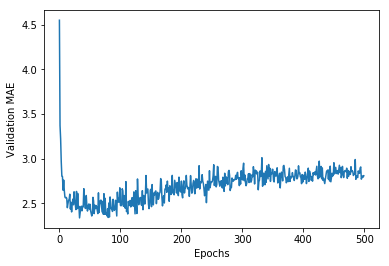

In [34]:
import matplotlib.pyplot as plt

plt.plot(range(num_epochs), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

#### Plot Smooth Curve

Steps:
 - Omit the first 10 points as they are on different scale than the rest of the curve
 - Replace each point with an exponential moving average of the previous points to get smooth curve


In [59]:
def smooth_curve(points, factor=0.9):
    smoothed_points=[]
    for point in points:
        if smoothed_points:
            previous=smoothed_points[-1]
            smoothed_points.append(previous*factor+point*(1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_avg_mae_history= smooth_curve(average_mae_history[10:])

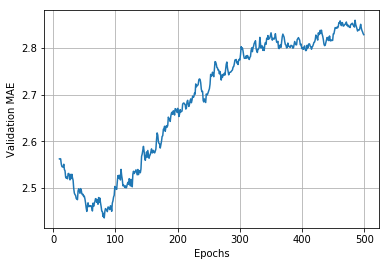

In [60]:
plt.plot(range(10,num_epochs), smooth_avg_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.grid()
plt.show()

According to this plot, validation MAE stops improving significantly after **80** epochs.
Past that point, network starts **overfitting**.

#### Fianl Model

In [63]:
model=build_model()
model.fit(train_data, train_targets, batch_size=16, epochs=80)

Epoch 1/80
404/404 [==============================] - 0s 852us/step - loss: 524.6746 - mean_absolute_error: 20.9808
Epoch 2/80
404/404 [==============================] - 0s 156us/step - loss: 376.6376 - mean_absolute_error: 17.2683
Epoch 3/80
404/404 [==============================] - 0s 149us/step - loss: 213.2205 - mean_absolute_error: 12.2730
Epoch 4/80
404/404 [==============================] - 0s 154us/step - loss: 90.9095 - mean_absolute_error: 7.3493
Epoch 5/80
404/404 [==============================] - 0s 166us/step - loss: 45.5699 - mean_absolute_error: 4.8910
Epoch 6/80
404/404 [==============================] - 0s 149us/step - loss: 32.3503 - mean_absolute_error: 4.0329
Epoch 7/80
404/404 [==============================] - ETA: 0s - loss: 24.0995 - mean_absolute_error: 3.53 - 0s 144us/step - loss: 25.7921 - mean_absolute_error: 3.6012
Epoch 8/80
404/404 [==============================] - 0s 154us/step - loss: 21.7621 - mean_absolute_error: 3.2767
Epoch 9/80
404/404 [========

404/404 [==============================] - 0s 141us/step - loss: 6.8629 - mean_absolute_error: 1.8539
Epoch 72/80
404/404 [==============================] - 0s 141us/step - loss: 6.8129 - mean_absolute_error: 1.8457
Epoch 73/80
404/404 [==============================] - 0s 141us/step - loss: 6.7466 - mean_absolute_error: 1.8275
Epoch 74/80
404/404 [==============================] - 0s 151us/step - loss: 6.6631 - mean_absolute_error: 1.8184
Epoch 75/80
404/404 [==============================] - 0s 144us/step - loss: 6.6819 - mean_absolute_error: 1.8064
Epoch 76/80
404/404 [==============================] - 0s 144us/step - loss: 6.6688 - mean_absolute_error: 1.8293
Epoch 77/80
404/404 [==============================] - 0s 142us/step - loss: 6.4744 - mean_absolute_error: 1.7911
Epoch 78/80
404/404 [==============================] - 0s 149us/step - loss: 6.5684 - mean_absolute_error: 1.8313
Epoch 79/80
404/404 [==============================] - 0s 139us/step - loss: 6.4497 - mean_absolute_

In [65]:
test_mse_score, test_mae_score= model.evaluate(test_data, test_targets)
print('Test MSE: ',test_mse_score)
print('Test MAE: ',test_mae_score)

102/102 [==============================] - 0s 3ms/step
Test MSE:  20.85398655311734
Test MAE:  2.9427760629092945
